# K-Nearest Neighbors (KNN) Regression for Settlement Value Prediction
This notebook trains a **KNN regression model** using the **already cleaned** dataset (`Patient_records.csv`).
It includes model training, evaluation, and a performance graph.

In [30]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime

Load and Preprocess Data

In [31]:
import pandas as pd
import numpy as np
from datetime import datetime

# Load dataset
file_path = "Patient_records.csv"
df = pd.read_csv(file_path)

# Step 1: Create 'duration_days' from 'Accident Date' and 'Claim Date'
if "Accident Date" in df.columns and "Claim Date" in df.columns:
    df["Accident Date"] = pd.to_datetime(df["Accident Date"], errors='coerce')
    df["Claim Date"] = pd.to_datetime(df["Claim Date"], errors='coerce')
    df["duration_days"] = (df["Claim Date"] - df["Accident Date"]).dt.days

# Step 2: Convert categorical features to numerical values
categorical_columns = df.select_dtypes(include=["object"]).columns
category_mappings = {}

for col in categorical_columns:
    unique_values = df[col].unique()
    mapping = {val: idx for idx, val in enumerate(unique_values)}
    df[col] = df[col].map(mapping)
    category_mappings[col] = mapping

# Step 3: Drop rows with any missing values
df_cleaned = df.dropna()

# Step 4: Remove highly correlated features
correlation_matrix = df_cleaned.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
df_cleaned = df_cleaned.drop(columns=highly_correlated_features, errors='ignore')

# Step 5: Save cleaned dataset
cleaned_file_path = "Cleaned_Patient_Records.csv"
df_cleaned.to_csv(cleaned_file_path, index=False)
print(f"✅ Data cleaned and saved to {cleaned_file_path}")

✅ Data cleaned and saved to Cleaned_Patient_Records.csv


## Implementing the KNN Model

In [32]:
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X):
        X = np.array(X)
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        self.std[self.std == 0] = 1  # Prevent division by zero

    def transform(self, X):
        X = np.array(X)
        return (X - self.mean) / self.std
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

class KNN:
    def __init__(self, k=50, regression=True):
        if k <= 0:
            raise ValueError("k must be a positive integer.")
        self.k = k
        self.regression = regression
        self.X_train = None
        self.y_train = None
        self.scaler = StandardScaler()

    def fit(self, X, y):
        self.X_train = self.scaler.fit_transform(np.array(X))
        self.y_train = np.array(y)
        
        if self.X_train.shape[0] < self.k:
            raise ValueError("k cannot be greater than the number of training samples.")
    
    def predict(self, X):
        X = self.scaler.transform(np.array(X))
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)
    
    def _predict(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_values = self.y_train[k_indices]
        
        if self.regression:
            return np.mean(k_nearest_values)  # Regression: Return average
        else:
            # Weighted voting by inverse distance
            class_votes = {}
            for i, idx in enumerate(k_indices):
                label = self.y_train[idx]
                weight = 1 / (distances[idx] + 1e-9)  # Avoid division by zero
                class_votes[label] = class_votes.get(label, 0) + weight
            
            return max(class_votes, key=class_votes.get)

class MLModule:
    def __init__(self):
        self.models = {}
    
    def add_model(self, name, model):
        if not isinstance(model, KNN):
            raise TypeError("Model must be an instance of KNN.")
        self.models[name] = model
    
    def train(self, name, X, y):
        if name in self.models:
            print(f"Training model '{name}' with {len(X)} samples...")
            self.models[name].fit(X, y)
        else:
            raise ValueError(f"Model '{name}' not found.")
    
    def predict(self, name, X):
        if name in self.models:
            return self.models[name].predict(X)
        else:
            raise ValueError(f"Model '{name}' not found.")

## Load Cleaned Data and Train KNN Model

In [33]:
# Load cleaned dataset
file_path = "Cleaned_Patient_Records.csv"
df_cleaned = pd.read_csv(file_path)

# Convert any object-type columns to numeric if missed
categorical_columns = df_cleaned.select_dtypes(include=["object"]).columns
category_mappings = {}
for col in categorical_columns:
    unique_values = df_cleaned[col].unique()
    mapping = {val: idx for idx, val in enumerate(unique_values)}
    df_cleaned[col] = df_cleaned[col].map(mapping)
    category_mappings[col] = mapping

# Separate features and target variable
X = df_cleaned.drop(columns=["SettlementValue"], errors='ignore').values.astype(float)
y = df_cleaned["SettlementValue"].values.astype(float)

# Safe Min-Max scaling
X_min = X.min(axis=0)
X_max = X.max(axis=0)
denom = np.where((X_max - X_min) == 0, 1, X_max - X_min)
X_scaled = (X - X_min) / denom

# Train KNN Regression
ml = MLModule()
knn_regressor = KNN(k=15, regression=True)
ml.add_model("knn_regressor", knn_regressor)
ml.train("knn_regressor", X_scaled, y)
print("KNN Regression Model Trained Successfully!")


Training model 'knn_regressor' with 3667 samples...
KNN Regression Model Trained Successfully!


In [34]:

# Weighted KNN prediction function
def weighted_knn_predict(X_train, y_train, X_test, k=20):
    predictions = []
    for x in X_test:
        distances = np.linalg.norm(X_train - x, axis=1)
        k_indices = np.argsort(distances)[:k]
        k_distances = distances[k_indices]
        k_weights = 1 / (k_distances + 1e-5)  # Avoid division by zero

        weighted_avg = np.dot(k_weights, y_train[k_indices]) / np.sum(k_weights)
        predictions.append(weighted_avg)
    
    return np.array(predictions)


## Model Performance: Actual vs Predicted Settlement Values

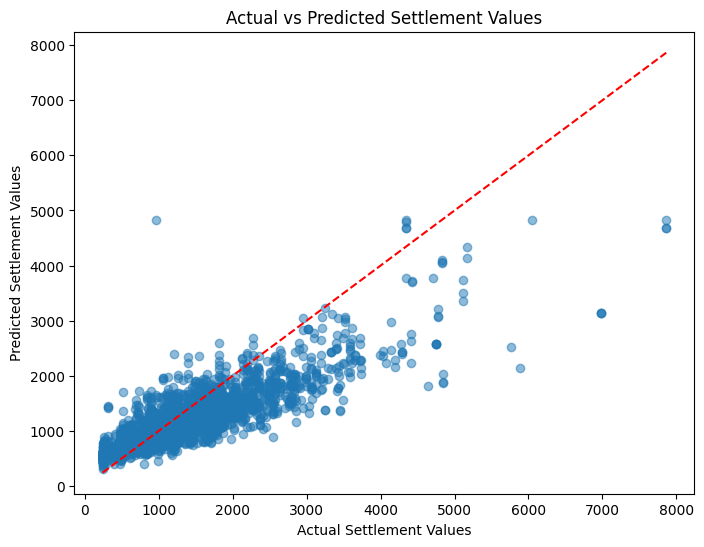

In [35]:

# Make predictions on the dataset
predictions = ml.predict("knn_regressor", X_scaled)

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, predictions, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='dashed')  # Perfect prediction line
plt.xlabel("Actual Settlement Values")
plt.ylabel("Predicted Settlement Values")
plt.title("Actual vs Predicted Settlement Values")
plt.show()


## Predict Settlement Value from User Input

In [36]:

# User input for prediction
print("Please enter values for the following features:")
user_input = []
feature_names = df_cleaned.drop(columns=["SettlementValue"], errors='ignore').columns

for feature in feature_names:
    value = float(input(f"{feature}: "))
    user_input.append(value)

# Normalize user input using the same scaling
user_input_scaled = (np.array(user_input) - X_min) / (X_max - X_min)

# Predict Settlement Value
prediction = ml.predict("knn_regressor", [user_input_scaled])
print(f"Predicted Settlement Value: {prediction[0]}")


Please enter values for the following features:


ValueError: could not convert string to float: ''